# Starbucks Capstone Challenge


## Project Overview 
Starbucks data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app that includes the transactions and offers events. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

In this project, I will try to optimize the promotion offer sending to customer. To achieve that goal, we need to understand the behavior of different group of customer to see whether their purchase are affected by offer or not 
need to answer the questions Which group of customer are more responsive to promotion offer? Do they increase the purchase compared with when they do not have any offer? 
  



## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record
 

## Section 1: Understanding  the business question 

###  Which group of customer is more responsive to promotion offer?
Many customers will possibly purchase Starbucks even though there aren’t any discount or promotion offer. So that will be more profitable if Starbucks doesn't send any promotion to those customers. Conversely, there may be some groups of customer who are very responsive to the promotion offers, they will only purchase or purchase more if there is some offer. For those customers, Starbuck may need to send the promotional offers. 
Therefore, it is crucial to find out which group is more responsive to Starbucks offers to optimize the promotion and maximize the profit.  

To answer this question, we need to analyze outcome metrics for the period of "feeling influenced by an offer" and the period of  "no offer available" for each specific demographic group of the customers to see if there is any change in "behavior" between the period with offers and period without offers. To do this, I will perform  "A/B-like testing" for each demographic group, which means I compare the outcome metrics across different offers treatment. Although I will not perform a statistical test for the significance difference, I will compare the absolute value outcomes. For example, if one customer has a high purchase per day during the days that he can use BOGO offer compared with the days he has no offer or informational offer, then Starbucks should send the BOGO offer to him 

**1. Identify the outcome metric**. 
Since the frequency of the purchase and the length of offer validation varies across offers, we need to normalize the purchase amount per a specific period and per offer.  Hence, the outcome metric I will analyze to answer this question is the **purchase amount per day per person**. during each period of  "feeling influenced by an offer."
If we compare the percentage of offer completed then we are not able to take into consideration of the informational offer or no offer, since we don't have the definition for offer completed in those two cases. 

**2. Define "feeling influenced by an offer" period**.

Assuming that the customer is feeling the influence of the offer from when he/she viewed the offer to when the offer expired, a period of  "feeling influenced by an offer" period is the period from when customer viewed the offer to when the offer expired. It should not contain the period before the offer was viewed since customers can't be affected by the offer if they are not aware of it even the offer was already sent to the customer. 

**3. Define "no offer" period**.

Period of "no offer available"  is the period that customers don't have any offer and are not aware of any offer or received offer but haven't viewed the offer yet, or offer already expired. 

**Since there are total 10 different offers sent to different customers, in addition to the "no offer"  case we will compare the outcomes across 11 possible treatment**. The 

**4. Group customers into cluster**.

Our main objective is to find how different group of customer response to the different promotion offer. Therefore, I will compare the metric outcomes across "feeling influenced by an offer" period for each specific customers group. 

**Import library**. 

In [1]:
# Import Library 
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns 
from matplotlib import pyplot as plt 
#from pandasql import sqldf


## Section 2 : Understanding the Data
In this section, I will explore the available datasets to see how the data is records, the information that data provide. 

####  Section 2.1: Profile data 

In [2]:
# import the profile file 
profile = pd.read_json('data/profile.json', orient = 'record', lines = True )

In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN



In this step, I will import three single file and look at the element as well as the distribution

We can see that there are totally 10 different type of offers belong to 3 categories: Buy one get one, discount, or informational.
bogo_10_10_7 refer to the BOGO which have the difficulty to be $10, get $10 rewards and have the duration of 7 days  

In [4]:

print(profile.shape)

(17000, 5)


Process the date time format 

In [5]:
# format the date 
profile['date'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
profile['became_member_month']= profile['date'].dt.month
profile['became_member_year']= profile['date'].dt.year
profile= profile.drop(['date'], axis = 1)

In [6]:
profile.head()

,age,became_member_on,gender,id,income,became_member_month,became_member_year
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2,2017
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,7,2017
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,7,2018
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,5,2017
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,8,2017


In [7]:
# check the missing value for each column in the profile data 

profile.isnull().sum(axis =0)/profile.shape[0] * 100 

age                     0.000000
became_member_on        0.000000
gender                 12.794118
id                      0.000000
income                 12.794118
became_member_month     0.000000
became_member_year      0.000000
dtype: float64

We can see that there are about 12.8% of the samples have missing value on income and gender. 
I decide to remove those rows with missing values. 

In [8]:
profile = profile.dropna()

In [9]:
# rename column to get more intuitive name 
profile = profile.rename(columns = {'id': 'person_id'})

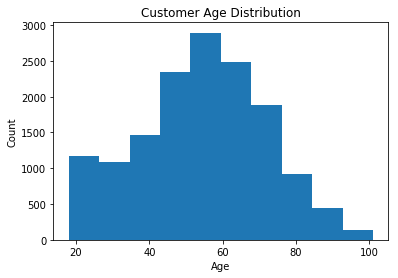

In [10]:
# age distribution 
plt.hist(profile['age'])
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age Distribution');

The largest proportion of Starbucks are in Aged 40 - 60 

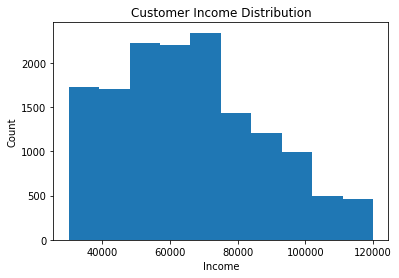

In [11]:
# income distribution 
plt.hist(profile['income'])
plt.xlabel('Income');
plt.ylabel('Count');
plt.title('Customer Income Distribution');

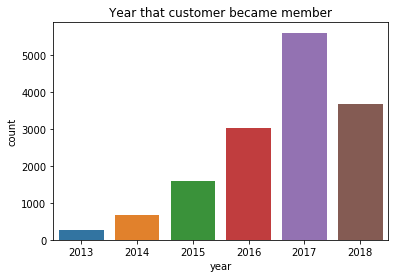

In [12]:
# year became member distribution 
ax = plt.subplot()
sns.countplot(data = profile, x = 'became_member_year', ax= ax )
ax.set_xlabel('year');
ax.set_ylabel('count');
ax.set_title('Year that customer became member');

#### Section 1.2: Portfolio file 

In [13]:
% matplotlib inline
# read in the portfolio files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)


**Feature engineering :**. 

Add new columns that can combine the characteristics of an offer to have in the convention:
category_difficulty_rewardamount_duration. 
For example the discount offer, buy $7 get $3 off and have the duration of 7 days will have the description as discount_7_3_7. 

The new column will be self-explanatory and more intuitive. 

In [14]:
# feature engineering : add new columns that can combine the characteristics of an offer to have all information in one columns 

portfolio['offer_desc'] = portfolio['offer_type'].map(str)+'_' +portfolio['difficulty'].map(str) +'_'+ portfolio['reward'].map(str) +'_' +portfolio['duration'].map(str)

# rename columns 'id' and columns 'difficulty' to get the intuitive name 
portfolio= portfolio.rename(columns = { 'difficulty': 'threshold'})


In [15]:
portfolio.head()

,channels,threshold,duration,id,offer_type,reward,offer_desc
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_10_7
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo_10_10_5
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,informational_0_0_4
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_5_7
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,discount_20_5_10


#### Section 1.3: Exploring the transcript data 

In [16]:
# Import the transcript file 

count =0
with open('data/transcript.json') as f:
    for line in f:
        count+=1

import ast
def read_json(n, file_name):
    f = open(file_name)
    data = []
    for i in range(n):
        line = f.readline()
        if line == "\n": 
            continue
        line = ast.literal_eval(line) # transform the string to dict 
        data.append(line)       
    return data 
    f.close()
    
data = read_json(count, 'data/transcript.json')
transcript = pd.DataFrame(data)
print(transcript.shape)


(306534, 4)


In [17]:
print(transcript.head())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  


In [18]:
# different types of event 
print(transcript['event'].value_counts())

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


(array([ 35540.,  13961.,  35789.,  17345.,  32589.,  42039.,  24307.,
         43552.,  44593.,  16819.]),
 array([   0. ,   71.4,  142.8,  214.2,  285.6,  357. ,  428.4,  499.8,
         571.2,  642.6,  714. ]),
 <a list of 10 Patch objects>)

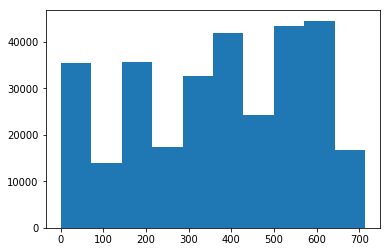

In [19]:
plt.hist(transcript['time'])

Transcript data contains the all the events happened, the column 'value' has the dictionary type with key is either "offer_id" or "amount", and with the value to be the offer_id, or the dollar amount depending on the event types. 

* Do feature engineering  by extracting the amount or the offer_id from the column 'value' and assign to the new columns. 
* Create new variable called "day" from variable time which indicates the hour. 

In [20]:
# clean the transcipt data:
# the value variable is a dictionary with offer id for offer event, or amount for transaction event 

print(type(transcript['value'][0]))

transcript['attribute_value'] = transcript['value'].apply(lambda x: list(x.values())[0])

transcript['event_attribute'] = transcript['value'].apply(lambda x: list(x.keys())[0])

# create the day base on time in hours 
transcript['day'] = transcript['time'].apply(lambda x: round(x/24))

transcript = transcript.drop('value', axis = 1)

<class 'dict'>


In [21]:
# explore the transcript file 
transcript.head()

# number of unique person in transcript file 
print("number of unique customers in transcript file is {}".format(transcript['person'].nunique()))

number of unique customers in transcript file is 17000


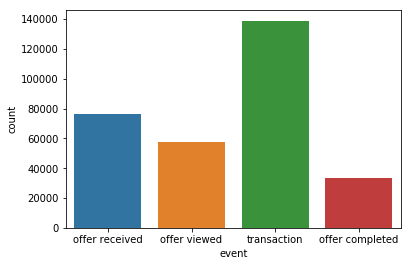

In [22]:
# plot the count of different types of event
fig, axes = plt.subplots()
sns.countplot(x = "event",  data=transcript, ax= axes)

## Section 3: Prepare the data for analysis 
We can see that from the transcript data frame, the "time" column has a value range from 0 to 718, which means it contains the events lasting for 30 days.
 
My strategy to prepare data for this analysis is creating a panel data frame, in which, each customer has 30 records(rows), each row corresponds to one day in 30 days.  I will initiate columns to indicate for each day, if a customer has any transaction (amount of that transaction), or has any offer available (offer type) on that day so that we can keep track of the all the events happened or did not happen for the entire 30 days. This way will allow us to analyze the outcome metric for all type of offer including "informational" or "no offer," and discount, and BOG. 


1. Divide the transcript data frame into individual data frames for each type of event. The transcript file contains 4 different types of event (offer received,  offer viewed, offer completed, transaction). So I will create 4 new data frames. For the offer received event, I will initiate the column offer_expired_day to indicate the day that offers are expired based on the duration of that offer. 

2.  I will create a table, in which each customer has 30 records corresponding to 30 days period of the transcript file. To have that data frame,  I expand the person profile to 30 records per person and create the column 'day' with the value from 1 to 30. 
 
2.  Then, I will merge this table with transaction events based on person_id and day to exhibit the purchase amount for each day. After joining the tables,  If we see missing transaction amount on a specific day,  that means there is no transaction for that person on that day,  I will encode it as transaction amount to be zero. 


3.  Merging the offer received event (that contain customer id, offer id, offer_received_day).  Then,  I join the offer_received table with "offer_viewed" table by person id and offer id. However, a customer may possibly receive one offer type(for example, 'discount of 2') multiple times. Therefore, we need to consider the time when the customer received the offer, offer duration, and time when the customer viewed the offer to determine which offer viewed belongs to which offer received. To merge the using inequality condition, we can't use the merge method in pandas. Thus, I will use the **pandasql**.  library to merge. Since the customer was not influenced by the offer if the customer never viewed the offer, I will use the inner join to capture only the offers that were both received and viewed by the customer. 

4. Then,  I will merge the table I created in step 2 with the table created in step 3 based on the person_id, offer_id. In addition, any day between when the offer was viewed and when the offer was expired will be assigned as the period that "feeling influenced by the offer"; otherwise 'no offer' will be assigned for that day. For example a customer received the offer BOGO_10_10_7 (buy one value at 10 dollars will get one free, expired in 7 days) on **day 10**.,  so the offer will be expired on day 17, but if he viewed the offer on day 14,  then any day between day 14 to day 17 will be assigned to the BOGO_10_10_7, any day between day 10 and day 13 will be assigned "No offer"


**Create data frame for each individual type of event**.

In [23]:
# define the function to extract the data for a specific type of event

def get_data(event): 
    """
    Input: the event type we need to extract. 
    Output: the data frame contains only the event we need, with more intuitive column names.  
    """
    # keep only the row with event we need to extract 
    
    df = transcript[transcript['event'] == event ]
    df['day'] = df['time']//24  +1 

    # keep only necessary columns
    df = df[['attribute_value', 'person', 'day']]
    
    # create the time name convention for each event: 
    # for example: "offer_viewed_day" to indicate the timing of offer viewed event ,
    # "offer_received_day" for offer received event
    
    time_name =   event.replace(" ", "_") +'_day'
    
    if event == 'transaction':
        df = df.rename(columns = {'attribute_value': 'transaction_amount','person': 'person_id', 'day': time_name})
    else:
        df = df.rename(columns = {'attribute_value': 'offer_id','person': 'person_id', 'day': time_name})
        
    return df 

In [24]:
# Get the individual file 
# transaction file 
transactions =  get_data("transaction")

# Offer received file 
offer_received = get_data("offer received")

# merge with the portfolio file to obtain the information of the offer_id that customer received 
offer_received = offer_received.merge(portfolio, left_on = 'offer_id', right_on = 'id',  how ='left')

# feature engineering: create the "offer_expired_day" columns to indicate the time that offer's valid based on the duration of the offer  
offer_received['offer_expired_day'] = offer_received['offer_received_day'] + offer_received['duration']

# Offer viewed file 
offer_viewed = get_data("offer viewed")

# Offer completed file 
offer_completed = get_data("offer completed")


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [25]:
offer_received.columns

Index(['offer_id', 'person_id', 'offer_received_day', 'channels', 'threshold',
       'duration', 'id', 'offer_type', 'reward', 'offer_desc',
       'offer_expired_day'],
      dtype='object')

**It is possible that a customer has multiple transactions per day, so I sum up the transactions amount of a customer by day**


In [26]:
# aggregate by person, day 

transactions = transactions.groupby(['person_id', 'transaction_day'])['transaction_amount'].sum().reset_index()

In [27]:
transactions.head()

,person_id,transaction_day,transaction_amount
0,0009655768c64bdeb2e877511632db8f,10,22.16
1,0009655768c64bdeb2e877511632db8f,18,8.57
2,0009655768c64bdeb2e877511632db8f,23,14.11
3,0009655768c64bdeb2e877511632db8f,24,13.56
4,0009655768c64bdeb2e877511632db8f,25,10.27


In [28]:
# keepn the neccessary columms 
offer_received = offer_received[['offer_id', 'person_id', 'offer_received_day','duration','offer_type', 'reward', 'offer_desc', 'offer_expired_day']]

In [29]:
offer_received.head()

,offer_id,person_id,offer_received_day,duration,offer_type,reward,offer_desc,offer_expired_day
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,1,7,bogo,5,bogo_5_5_7,8
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,1,10,discount,5,discount_20_5_10,11
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,1,7,discount,2,discount_10_2_7,8
3,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,1,10,discount,2,discount_10_2_10,11
4,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,1,5,bogo,10,bogo_10_10_5,6


In [30]:
offer_viewed.head()

,offer_id,person_id,offer_viewed_day
12650,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,1
12651,5a8bc65990b245e5a138643cd4eb9837,d1ede868e29245ea91818a903fec04c6,1
12652,4d5c57ea9a6940dd891ad53e9dbe8da0,102e9454054946fda62242d2e176fdce,1
12653,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c,1
12655,5a8bc65990b245e5a138643cd4eb9837,be8a5d1981a2458d90b255ddc7e0d174,1


In [31]:
# check if there is duplicate in offer completed events data 

offer_completed[offer_completed.duplicated(keep = False)].head()

,offer_id,person_id,offer_completed_day
66122,2906b810c7d4411798c6938adc9daaa5,3dde94fa581145cb9f206624f1a94d5a,8
66123,2906b810c7d4411798c6938adc9daaa5,3dde94fa581145cb9f206624f1a94d5a,8
66782,ae264e3637204a6fb9bb56bc8210ddfd,e9fb6ed2cecb4980ba98c86abc9c91e3,8
66783,ae264e3637204a6fb9bb56bc8210ddfd,e9fb6ed2cecb4980ba98c86abc9c91e3,8
67613,9b98b8c7a33c4b65b9aebfe6a799e6d9,a7dc060f6fc94ca7bf71fbb188187dca,8


In [32]:
# print the size of each table 
print("the size of offer received data is:  {}".format(offer_received.shape))
print("the size of offer viewed data is: {}".format(offer_viewed.shape))
print("the size of offer completed data is: {}".format(offer_completed.shape))

the size of offer received data is:  (76277, 8)
the size of offer viewed data is: (57725, 3)
the size of offer completed data is: (33579, 3)


**Create panel data: Expand the profile dataframe to 30 rows for each person and create new columns of day with value from 1-30**.  

In [33]:
# create a new data profile data frame at the person-day level, that each person will have 30 rows of data 
profile_person_day = pd.concat([profile]*30)
profile_person_day.shape
profile_person_day = profile_person_day.sort_values(by = 'person_id')
profile_person_day['day'] = profile_person_day.groupby(['person_id']).cumcount()+1


In [34]:
# check the unique transaction_day in the transaction file 

transactions['transaction_day'].nunique()

30

**Merge the expand profile_person_day df with transaction event df to get the panel data for customer** 

In [35]:
# merge the profile_person_day data frame with the transaction data frame 
# base on person_id and time of the transaction 

transactions_30days = pd.merge(profile_person_day, transactions, how = 'left', left_on = ['person_id','day'], 
                                   right_on =['person_id','transaction_day'])

# for those person- day without any transaction, the transaction_amount will be missing after we do "merge"
# replace the NaN value with zeros for the transaction_amount column 
transactions_30days['transaction_amount'] = transactions_30days['transaction_amount'].fillna(0)

transactions_30days = transactions_30days.drop(['transaction_day'], axis = 1)

# after merging the data will look like following
transactions_30days.head(n=15)



,age,became_member_on,gender,person_id,income,became_member_month,became_member_year,day,transaction_amount
0,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,1,0.00
1,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,2,0.00
2,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,3,0.00
3,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,4,0.00
4,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,5,0.00
5,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,6,0.00
6,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,7,0.00
7,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,8,0.00
8,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,9,0.00
9,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,10,22.16


**Join the offer_received table with the offer_viewed table to determine when offer has been viewed by the customers after customers received the offer**. 

Recall that merge or join method in pandas only allows us to join or merge different tables with equality conditions. 
However, to merge the offer_received table and offer_viewed table, we need to merge base on both equality and inequality conditions. Since one customer may receive one offer type multiple times during that period, we will assign the wrong offer viewed event to the offer received event if we rely on only the offer id and person id. Hence  we need to take into account the time point that customer viewed the offer, and the time point the customer received the offer, as well as the time point that the offer expired.

The 'pandasql' library allows us to work similarly to SQL so that we can join tables with inequality conditions. Therefore, I will use that libraries to join the individual dataframes more easily.  

**IMPORTANT:  We have to install pandasql library in the terminal using the command:  conda install -c anaconda pandasql**. 

I will join the offer_received table and offer_viewed table based on 3 conditions:
* person_id 
* offer_id 
* time_viewed fall within the range of the time_received and time_expired 



In [36]:
from pandasql import sqldf

**Create a table that join the offer received event and offer viewed event**. 

In [37]:
# create tables that inner join the received event with the viewed event based on the person_id, offer_id
# and whether the time that customer viewed the offer fall into time between offer was received and when offer was expired 
# the output data frame will include all the offer that customers both received and viewed 

q = """SELECT distinct 
        r.*, v.offer_viewed_day
        FROM
        offer_received r 
     INNER JOIN
        offer_viewed v 
           ON r.person_id = v.person_id
           and r.offer_id = v.offer_id
            and r.offer_received_day <= v.offer_viewed_day 
           and r.offer_expired_day >= v.offer_viewed_day 
        
               
ORDER BY person_id, 
            offer_id, 
            offer_received_day, 
            offer_viewed_day, 
            offer_expired_day

     ;"""

received_viewed = sqldf(q, globals())

#received_viewed_inner.head()

In [38]:
received_viewed.head()

,offer_id,person_id,offer_received_day,duration,offer_type,reward,offer_desc,offer_expired_day,offer_viewed_day
0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,15,4,informational,0,informational_0_0_4,19,16
1,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,8,3,informational,0,informational_0_0_3,11,9
2,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,18,5,bogo,5,bogo_5_5_5,23,20
3,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,22,10,discount,2,discount_10_2_10,32,23
4,f19421c1d4aa40978ebb69ca19b0e20d,00116118485d4dfda04fdbaba9a87b5c,8,5,bogo,5,bogo_5_5_5,13,10


**Merge the transactions_30days with the received_viewed_inner data frame**. 
* received_viewed_inner: contain all the offers have been received and viewed, with the view dayed and expired day 
* transactions_30days: contains all 30 records for each person, which each record correspond to one day.The transaction_amount present the purchase amount that person has made on that day. If no purchase is made, the transaction_amount is recorded to be zero. 
We already have 30 days of data for each customer. Now we need to know if on a particular day, customer is aware of having a offer (or viewing the offer) and offer is still valid. Therefore, the day within the range of day viewed and day expired will be the day that customer can be influenced by the offer.  

In [39]:
# create tables join the transactions_30days data with received_viewed_inner

q = """SELECT distinct 
        p.*, 
      
        r.offer_desc as offer_avail
        FROM transactions_30days p 
     LEFT JOIN received_viewed r 
           
           ON p.person_id = r.person_id
           and p.day >= r.offer_viewed_day  
           and p.day <= r.offer_expired_day
            ;"""

df = sqldf(q, globals())


In [40]:
df.head(n=30)

,age,became_member_on,gender,person_id,income,became_member_month,became_member_year,day,transaction_amount,offer_avail
0,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,1,0.00,None
1,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,2,0.00,None
2,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,3,0.00,None
3,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,4,0.00,None
4,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,5,0.00,None
5,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,6,0.00,None
6,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,7,0.00,None
7,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,8,0.00,None
8,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,9,0.00,informational_0_0_3
9,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,10,22.16,informational_0_0_3


After merging the transactions_30days df with the received_viewed_inner data, we will see that the column 'offer_desc' will have missing value if there is no offers available for that customer on that day. I will replace those missing value with "No offer" to indicate that customer has no offer to use on that dat. 

In [41]:
# replace missing value for offer_desc as 'No offer'
df['offer_avail'].replace(to_replace = [None], value = 'No offer', inplace = True)

In [42]:
df.head(n=20)

,age,became_member_on,gender,person_id,income,became_member_month,became_member_year,day,transaction_amount,offer_avail
0,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,1,0.00,No offer
1,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,2,0.00,No offer
2,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,3,0.00,No offer
3,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,4,0.00,No offer
4,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,5,0.00,No offer
5,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,6,0.00,No offer
6,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,7,0.00,No offer
7,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,8,0.00,No offer
8,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,9,0.00,informational_0_0_3
9,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,4,2017,10,22.16,informational_0_0_3


####  Calculate the purchase amount per day for each period of different treatment

As we can see, the table df contain the data of transaction amount for each day in the period of 30 days. And for each day, we know what type of "treatment" offer customer can used. Now, I will calculate the average purchase amount per day for each customer for each "treatment" period from when customer viewed the offer to when the offer expired, and for period that the no offer  

In [43]:
df_summary = df.groupby(['person_id','gender','income' , 'age' , 'became_member_year', 'became_member_month','offer_avail']).aggregate(np.mean)[['transaction_amount']].reset_index().rename(columns = {'transaction_amount': 'transaction_amt_perday'})

In [44]:
df_summary.head(n=50)

,person_id,gender,income,age,became_member_year,became_member_month,offer_avail,transaction_amt_perday
0,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,No offer,0.000000
1,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,bogo_5_5_5,3.527500
2,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,discount_10_2_10,12.108750
3,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,informational_0_0_3,7.386667
4,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,informational_0_0_4,2.142500
5,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,No offer,4.496667
6,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,bogo_5_5_7,6.755000
7,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,discount_20_5_10,5.404000
8,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,discount_7_3_7,1.491250
9,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,informational_0_0_3,0.000000


**The table above indicates that person "0009655768c64bdeb2e877511632db8f" have no transaction for the days that he does not have any offer, 3.53 dollar purchase perday when he have the BOGO with minumim amount of 5 dollars, or 12.1 dollars per day when he have the discount offer buy 10 dollars get 2 dollar off, 7.4 dollar per day when they receive the informational offer about the product**. 

In [45]:
df_summary[df_summary['offer_avail'] == 'No offer' ]

,person_id,gender,income,age,became_member_year,became_member_month,offer_avail,transaction_amt_perday
0,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,No offer,0.000000
5,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,No offer,4.496667
11,0020c2b971eb4e9188eac86d93036a77,F,90000.0,59,2016,3,No offer,3.648462
14,0020ccbbb6d84e358d3414a3ff76cffd,F,60000.0,24,2016,11,No offer,1.479091
19,003d66b6608740288d6cc97a6903f4f0,F,73000.0,26,2017,6,No offer,0.582727
23,00426fe3ffde4c6b9cb9ad6d077a13ea,F,65000.0,19,2016,8,No offer,0.638750
26,004b041fbfe44859945daa2c7f79ee64,F,74000.0,55,2018,5,No offer,4.310000
29,004c5799adbf42868b9cff0396190900,M,99000.0,54,2016,3,No offer,0.000000
32,005500a7188546ff8a767329a2f7c76a,M,47000.0,56,2017,12,No offer,0.000000
34,0056df74b63b4298809f0b375a304cf4,M,91000.0,54,2016,8,No offer,1.724375


## Section 4: Analyze the data 
**Compare the outcome metrics across different offers for each cluster of customer using k-means clustering **.

In this section, instead of dividing customer into groups based on single characteristics, I use K-mean clustering to group customer into a group based on all the characteristics (age, gender, income, membership start year) at the same time. 

I need to normalize the data using standard scaler. 
Then, I cluster data with a different number of cluster and use the elbow curve rule to determine the optimal number of groups. 
Finally, I group the customer into the cluster and compare the outcome metrics across offers for each cluster of customers to see how each cluster response to each type of offer. 

In [52]:
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import Imputer 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
import datetime

In [48]:
profile.head()

,age,became_member_on,gender,person_id,income,became_member_month,became_member_year
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,7,2017
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,5,2017
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4,2018
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2,2018
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,11,2017


In [49]:
# keep the customer charatersistic columns before doing the clustering 
profile1 = profile[[ 'age', 'income', 'gender', 'became_member_year']]

In [54]:
profile1 = pd.get_dummies(profile1, columns = ['gender'])

In [55]:
profile1.head()

,age,income,became_member_year,gender_F,gender_M,gender_O
1,55,112000.0,2017,1,0,0
3,75,100000.0,2017,1,0,0
5,68,70000.0,2018,0,1,0
8,65,53000.0,2018,0,1,0
12,58,51000.0,2017,0,1,0


In [56]:
# normalize data before doing clustering

scaler = StandardScaler()
columns = profile1.columns
profile_scaled = scaler.fit_transform(profile1)
profile_scaled = pd.DataFrame(profile_scaled, columns = columns )


In [57]:
profile_scaled.head()

,age,income,became_member_year,gender_F,gender_M,gender_O
0,0.034889,2.157419,0.317000,1.191146,-1.156702,-0.120448
1,1.185430,1.601801,0.317000,1.191146,-1.156702,-0.120448
2,0.782741,0.212756,1.151582,-0.839528,0.864527,-0.120448
3,0.610160,-0.574370,1.151582,-0.839528,0.864527,-0.120448
4,0.207470,-0.666973,0.317000,-0.839528,0.864527,-0.120448


In [58]:
# function to do the clustering with different value of K

from sklearn.cluster import KMeans 
def clustering(data, k): 
    kmean = KMeans(n_clusters = k )
    kmean.fit(data)
    clusters = kmean.predict(data)
    inertia = kmean.inertia_
    return inertia 
    

**Experiment cluster data with different number of clusters to find the best number of cluster**.

In [59]:
k_values  = [1,2,3,4,5,6,7,8, 9,10,11, 12, 13,14, 15]
SSE = []


for k in k_values:
    kmean = KMeans(n_clusters = k )
    kmean.fit(profile_scaled)
    clusters = kmean.predict(profile_scaled)
    inertia = kmean.inertia_
    
    SSE.append(inertia)
    
    

Text(0.5,1,'Elbow curve')

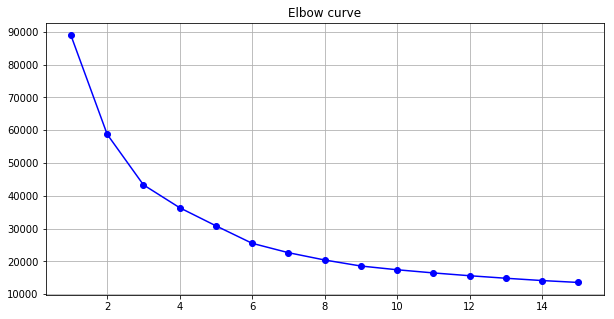

In [60]:
# plot the SSE against the k value 
fig = plt.subplots(figsize= (10, 5))
plt.plot(k_values, SSE,  marker='o', color='b')
plt.grid(True)
plt.title('Elbow curve')


The "elbow" curve graph above shows that the optimal number of clusters should be 6. Therefore, I will cluster customer into 6 clusters  

In [61]:
kmean = KMeans(n_clusters = 6)
kmean.fit(profile_scaled)
clusters = kmean.labels_
print(len(clusters))
profile.shape

14825


(14825, 7)

In [64]:
# merge predict cluster group  with the original profile file to assign customer the cluster number that he/she belongs to. 


profile['cluster']=clusters
profile['cluster'].value_counts()


0    3494
2    3473
1    3350
3    2735
5    1561
4     212
Name: cluster, dtype: int64

In [65]:
profile.head()

,age,became_member_on,gender,person_id,income,became_member_month,became_member_year,cluster
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,7,2017,1
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,5,2017,1
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4,2018,0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2,2018,0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,11,2017,2


In [66]:
# obtain the cluster number of each customer in the df_summary file 
data_with_cluster = df_summary.merge(profile[['person_id', 'cluster']], on = 'person_id', how = 'left')
data_with_cluster.head()

,person_id,gender,income,age,became_member_year,became_member_month,offer_avail,transaction_amt_perday,cluster
0,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,No offer,0.000000,2
1,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,bogo_5_5_5,3.527500,2
2,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,discount_10_2_10,12.108750,2
3,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,informational_0_0_3,7.386667,2
4,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,informational_0_0_4,2.142500,2




After look at characteristics of each cluster at below, I have the following observations:  
* Cluster number 0: Gender Female, with medium to high income , age above 40
* Cluster number 1: Gender Male, with medium to high income , age above 40 , join Starbucks since 2016 
* Cluster number 2: Gender other, with average to high income , age above 40 
* Cluster number 3: Gender Male, newly join Starbuck ( year 2017, 2018), younger compared with other. 
* Cluster number 4  Female, either younger(age below 40) or older( age above 60) 
* cluster number 5: Male,  have joined Starbucks for a few years (before 2015), middle to older age (above 40) 


In [67]:
data_with_cluster[data_with_cluster['cluster'] ==0].head()

,person_id,gender,income,age,became_member_year,became_member_month,offer_avail,transaction_amt_perday,cluster
29,004c5799adbf42868b9cff0396190900,M,99000.0,54,2016,3,No offer,0.000000,0
30,004c5799adbf42868b9cff0396190900,M,99000.0,54,2016,3,bogo_5_5_5,13.812000,0
31,004c5799adbf42868b9cff0396190900,M,99000.0,54,2016,3,discount_10_2_10,14.947143,0
34,0056df74b63b4298809f0b375a304cf4,M,91000.0,54,2016,8,No offer,1.724375,0
35,0056df74b63b4298809f0b375a304cf4,M,91000.0,54,2016,8,bogo_5_5_7,3.980000,0


In [68]:
data_with_cluster[data_with_cluster['cluster'] ==1].head()

,person_id,gender,income,age,became_member_year,became_member_month,offer_avail,transaction_amt_perday,cluster
11,0020c2b971eb4e9188eac86d93036a77,F,90000.0,59,2016,3,No offer,3.648462,1
12,0020c2b971eb4e9188eac86d93036a77,F,90000.0,59,2016,3,bogo_10_10_5,8.516667,1
13,0020c2b971eb4e9188eac86d93036a77,F,90000.0,59,2016,3,discount_10_2_10,8.939091,1
26,004b041fbfe44859945daa2c7f79ee64,F,74000.0,55,2018,5,No offer,4.310000,1
27,004b041fbfe44859945daa2c7f79ee64,F,74000.0,55,2018,5,bogo_5_5_5,4.653333,1


In [69]:
data_with_cluster[data_with_cluster['cluster'] ==2].head()

,person_id,gender,income,age,became_member_year,became_member_month,offer_avail,transaction_amt_perday,cluster
0,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,No offer,0.000000,2
1,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,bogo_5_5_5,3.527500,2
2,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,discount_10_2_10,12.108750,2
3,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,informational_0_0_3,7.386667,2
4,0009655768c64bdeb2e877511632db8f,M,72000.0,33,2017,4,informational_0_0_4,2.142500,2


In [74]:
#  Cluster number 3

data_with_cluster[data_with_cluster['cluster'] ==3].head()

,person_id,gender,income,age,became_member_year,became_member_month,offer_avail,transaction_amt_perday,cluster
14,0020ccbbb6d84e358d3414a3ff76cffd,F,60000.0,24,2016,11,No offer,1.479091,3
15,0020ccbbb6d84e358d3414a3ff76cffd,F,60000.0,24,2016,11,bogo_5_5_5,12.233333,3
16,0020ccbbb6d84e358d3414a3ff76cffd,F,60000.0,24,2016,11,bogo_5_5_7,3.558000,3
17,0020ccbbb6d84e358d3414a3ff76cffd,F,60000.0,24,2016,11,discount_7_3_7,5.823750,3
18,0020ccbbb6d84e358d3414a3ff76cffd,F,60000.0,24,2016,11,informational_0_0_3,14.717500,3


In [71]:
#  Cluster number 4

data_with_cluster[data_with_cluster['cluster'] ==4].head()

,person_id,gender,income,age,became_member_year,became_member_month,offer_avail,transaction_amt_perday,cluster
5,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,No offer,4.496667,4
6,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,bogo_5_5_7,6.755000,4
7,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,discount_20_5_10,5.404000,4
8,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,discount_7_3_7,1.491250,4
9,0011e0d4e6b944f998e987f904e8c1e5,O,57000.0,40,2018,1,informational_0_0_3,0.000000,4


In [72]:
#  Cluster number 5
data_with_cluster[data_with_cluster['cluster'] ==5].head()

,person_id,gender,income,age,became_member_year,became_member_month,offer_avail,transaction_amt_perday,cluster
46,00840a2ca5d2408e982d56544dc14ffd,M,61000.0,26,2014,12,No offer,0.765000,5
47,00840a2ca5d2408e982d56544dc14ffd,M,61000.0,26,2014,12,discount_10_2_10,1.984000,5
48,00840a2ca5d2408e982d56544dc14ffd,M,61000.0,26,2014,12,discount_10_2_7,4.238750,5
70,00ae03011f9f49b8a4b3e6d416678b0b,M,83000.0,55,2015,11,No offer,0.000000,5
71,00ae03011f9f49b8a4b3e6d416678b0b,M,83000.0,55,2015,11,bogo_10_10_7,9.194286,5


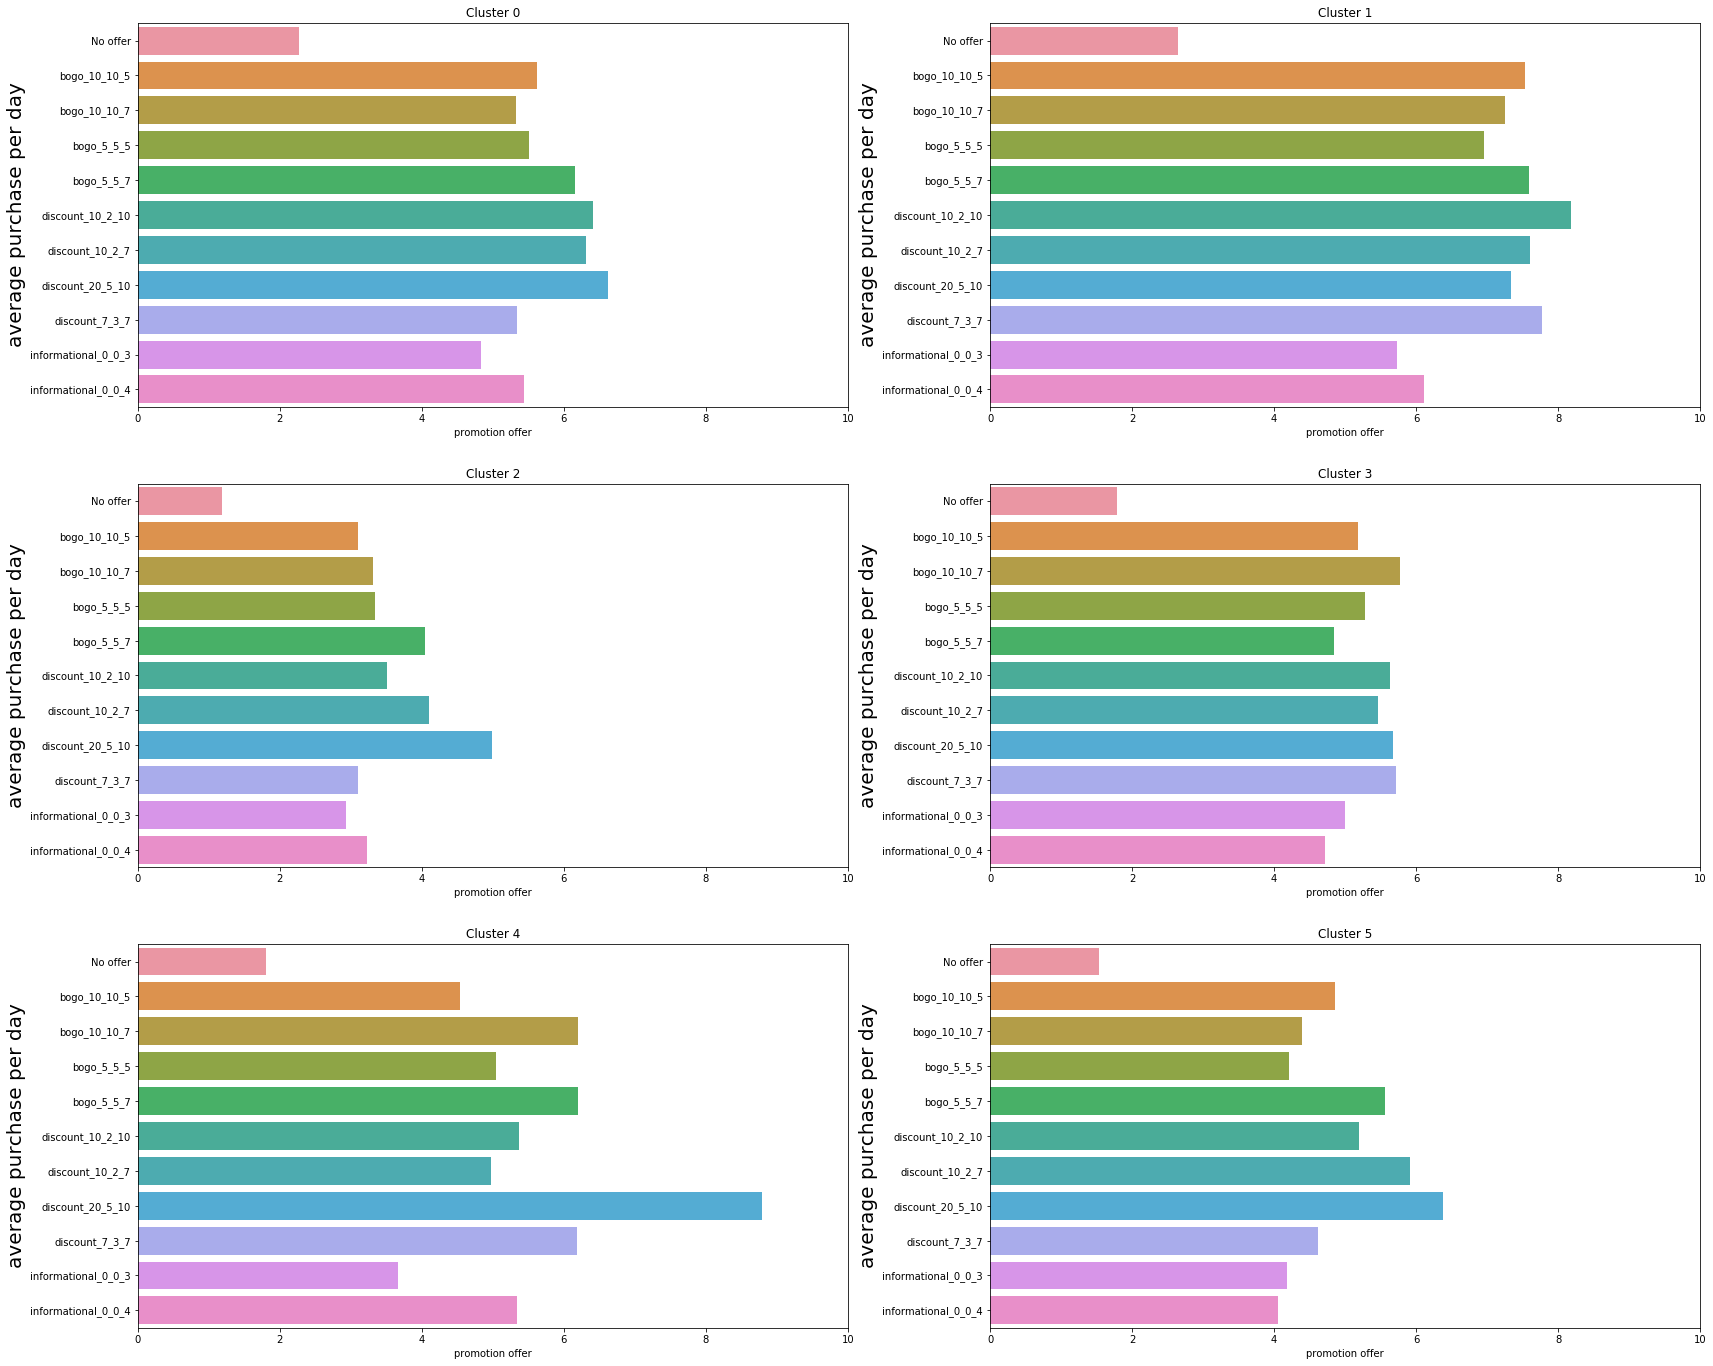

In [73]:
# Plot the average purchase amount for different cluster of customer 

    # the Figure contain subplots with dimension 2* round(number_group//2)
fig, ax = plt.subplots(3, 2, figsize =(28, 24), squeeze=False) 

for i in range(6):
    df = data_with_cluster[data_with_cluster['cluster'] == i]
    df =  (df.groupby(['offer_avail']).aggregate(np.mean)['transaction_amt_perday'].reset_index() .sort_values(by = ['offer_avail']))
        
    axes = ax[i//2][i%2]
    sns.barplot(y = "offer_avail", x = "transaction_amt_perday",   data = df, ax= axes)
    axes.set_xlabel('promotion offer')
    axes.set_xlim(0, 10)
    axes.set_ylabel('average purchase per day',  fontsize=20)
    axes.set_title("Cluster {}".format(i))


**DISCUSSION**. 

The graph shows a very different pattern across customer cluster in term of purchase amount per day with different offer availability. 
* Cluster 0 have quite stable purchase across discount and BOGO offer, they also have quite good amount of purchase with informational offer 

* Cluster 1, in general, have the highest purchase. Their response to Discount and BOGO offer is quite similar. When they have the informational offer, their purchase is still high (but not as high as discount and BOGO). So Starbucks can send the informational offers to them as well.   As describe above, these group both have good to high income.
* cluster 2 are very responsive to the Discount(buy 20 dollars get 5 off) , they increase their purchase per day approximately more than 50 percent on average when they got this offer compared to other offers. This group mostly has "Other" gender, good to high income. Hence, We should send this group this offer to increase their purchase . 
* Cluster 3 has the lowest average purchase compare with the rest.  However, they seem to be responsive to the Discount(buy 20 dollars get 5 off). They are mostly male, newly join Starbuck app. We may send the discount(buy 20 dollars get 5 off) too. 
* Cluster 4 has quite stable purchase across the offer. We can send the informational offer to get more profit from this group
* Cluster 5 is more responsive to all Discount offers  and BOGO with minimum amount to be 5 dollars) 

One more interesting thing is that, although the informational offer does not offer any monetary value, they still increase purchase among all customer compared with no offer case. We should send this offer more often, since it can increase revenue, and does not reduce the profit margin .


## Section 5: Conclusion 

In this project, I analyze Starbucks data to examine how the customer response to a different type of offers from Starbucks. My contribution is I cleaned and transform data to the new form  that we can compute and compare outcome metrics (average purchase per day) at the same scaled across offers for each customer group 

From my analysis above, we can see that different group of customer have different purchase behavior and response differently to the offers they got. Base on the result, we can optimize the offer sending to customer.